<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/gold_with_macro_corelation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed
<ipython-input-4-bef19613d21c>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)
<ipython-input-4-bef19613d21c>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='bfill', inplace=True)
<ipython-input-4-bef19613d21c>:78: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-4-bef19613d21c>:79: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


0
0
2022-01-03    1.137346
2022-01-04    1.130224
2022-01-05    1.128363
2022-01-06    1.131350
2022-01-07    1.129688
2022-01-10    1.135396
2022-01-11    1.133042
2022-01-12    1.136648
2022-01-13    1.144165
2022-01-14    1.145712
Name: Close, dtype: float64
2024-06-18    1.074068
2024-06-19    1.074229
2024-06-20    1.075153
2024-06-21    1.070641
2024-06-24    1.068776
2024-06-25    1.073272
2024-06-26    1.070962
2024-06-27    1.068011
2024-06-28    1.070847
2024-07-01    1.073526
Name: Close, dtype: float64


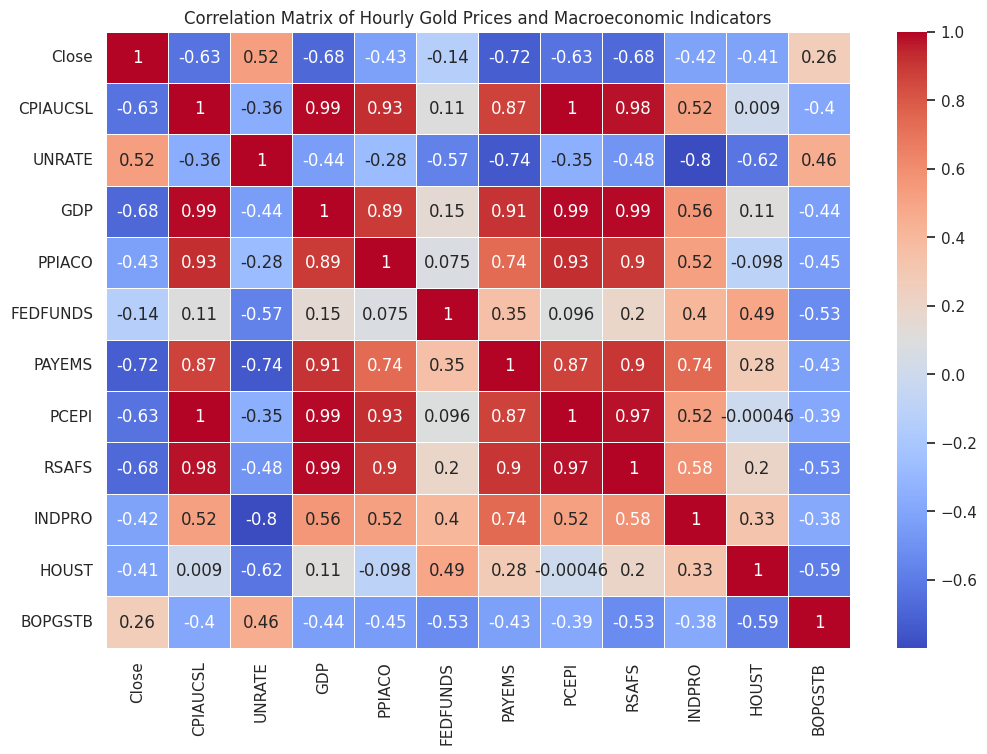

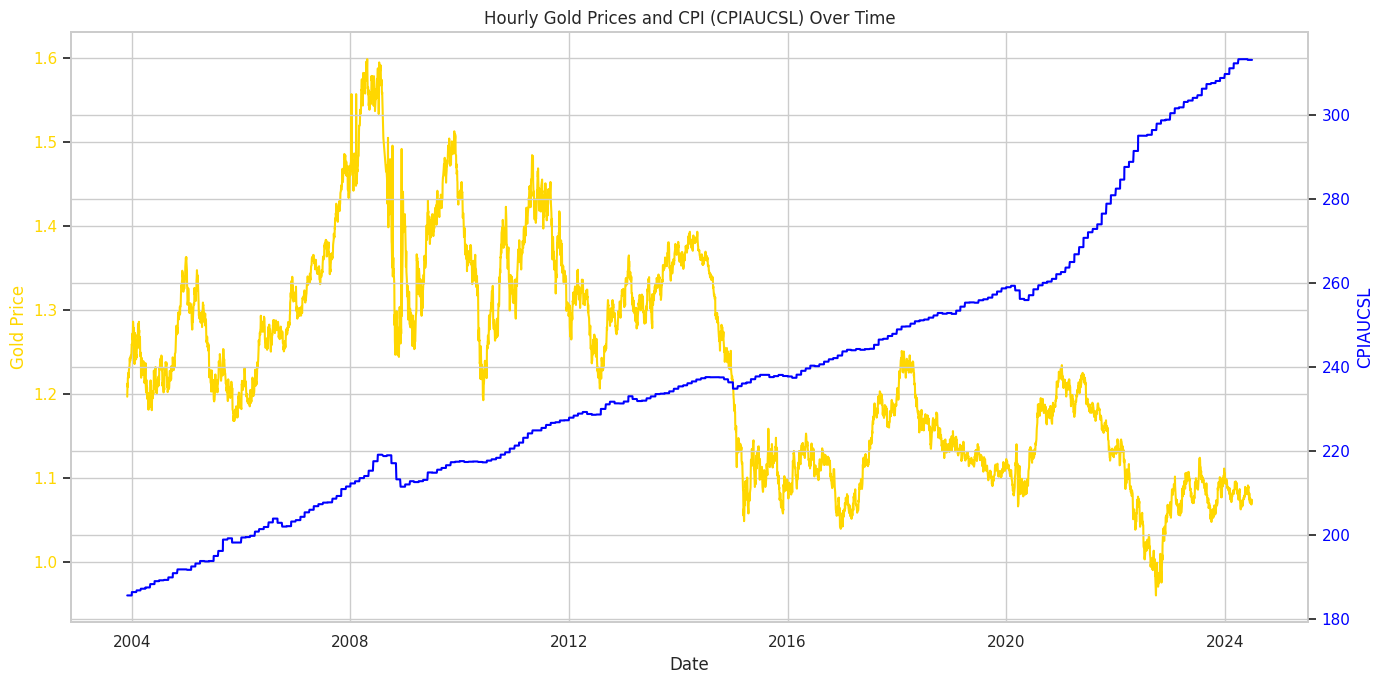

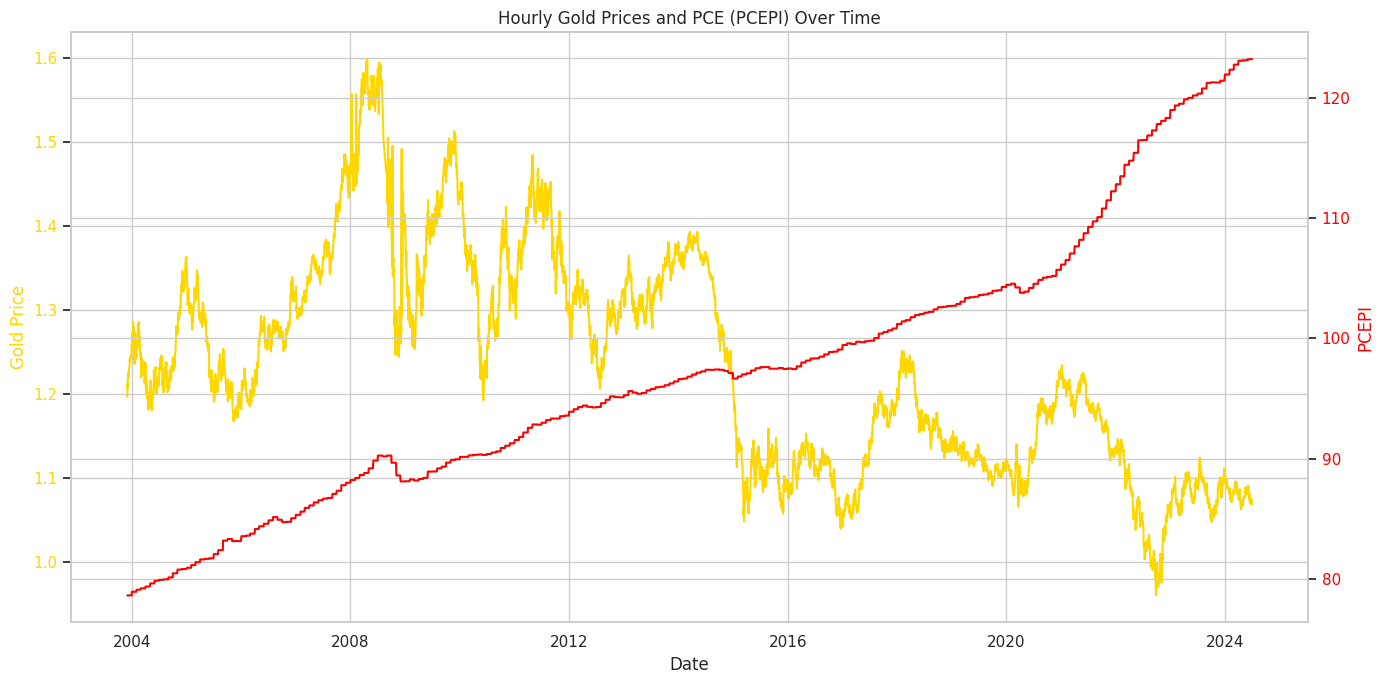

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'].str.replace(',', ''), errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    return None

# Replace with your FRED API key
fred_api_key = 'xx'

# Fetch hourly gold price data using yfinance
gold_data = yf.download('EURUSD=X', start='2000-01-01', end='2024-08-07', interval='1d')

# Ensure the 'Close' column exists
if 'Close' not in gold_data.columns:
    raise ValueError("The 'Close' column is missing from the gold data.")

# List of FRED series IDs
series_ids = [
    'CPIAUCSL', 'UNRATE', 'GDP', 'PPIACO', 'FEDFUNDS', 'PAYEMS',
    'PCEPI', 'RSAFS', 'INDPRO', 'HOUST', 'BOPGSTB'
]

# Download FRED data and concatenate into a single DataFrame
fred_data = [download_fred_data(series_id, fred_api_key) for series_id in series_ids]
fred_data = [df for df in fred_data if df is not None]
macro_data = pd.concat(fred_data, axis=1)

# Convert macro_data index to timezone-naive if necessary
if macro_data.index.tz:
    macro_data.index = macro_data.index.tz_convert(None)

# Resample macroeconomic data to match hourly frequency, filling forward
macro_data = macro_data.resample('1d').ffill()

# Check for missing values and handle them
macro_data.fillna(method='ffill', inplace=True)
macro_data.fillna(method='bfill', inplace=True)

# Check for any remaining missing values
if macro_data.isnull().sum().sum() > 0:
    print("Warning: There are still missing values in the macroeconomic data.")

# Convert gold_data index to timezone-naive if necessary
if gold_data.index.tz:
    gold_data.index = gold_data.index.tz_convert(None)

# Merge macroeconomic data with hourly gold price data
data = gold_data.join(macro_data, how='inner')

# Handle missing values before calculating correlations
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Select relevant features to reduce state space size
selected_features = ['Close', 'CPIAUCSL', 'UNRATE', 'GDP', 'PPIACO', 'FEDFUNDS', 'PAYEMS',
                     'PCEPI', 'RSAFS', 'INDPRO', 'HOUST', 'BOPGSTB']
data = data[selected_features]

# Convert all data to numeric (float) to ensure compatibility for correlation calculation
data = data.apply(pd.to_numeric, errors='coerce')

# Check for missing values in the 'Close' column
print(data['Close'].isnull().sum())
print(data['Close'].loc['2022':].isnull().sum())

# Print data to check for values
print(data['Close'].loc['2022':].head(10))  # Check the first 10 entries
print(data['Close'].loc['2022':].tail(10))  # Check the last 10 entries

# Calculate the correlation matrix
corr_matrix = data.corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Hourly Gold Prices and Macroeconomic Indicators')
plt.show()

# Plot CPIAUCSL (CPI) against Gold Price
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Gold Price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color='gold')
ax1.plot(data.index, data['Close'], label='Gold Price', color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

# Create a second y-axis for CPIAUCSL (CPI)
ax2 = ax1.twinx()
ax2.set_ylabel('CPIAUCSL', color='blue')
ax2.plot(data.index, data['CPIAUCSL'], label='CPIAUCSL', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add titles and legend
plt.title('Hourly Gold Prices and CPI (CPIAUCSL) Over Time')
fig.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

# Plot PPIACO (PPI) against Gold Price
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Gold Price on the left y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Gold Price', color='gold')
ax1.plot(data.index, data['Close'], label='Gold Price', color='gold')
ax1.tick_params(axis='y', labelcolor='gold')

# Create a second y-axis for PPIACO (PPI)
ax2 = ax1.twinx()
ax2.set_ylabel('PCEPI', color='red')
ax2.plot(data.index, data['PCEPI'], label='PCEPI', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add titles and legend
plt.title('Hourly Gold Prices and PCE (PCEPI) Over Time')
fig.tight_layout()  # Adjust the layout to prevent overlap
plt.show()

In [ ]:
import requests
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure seaborn style
sns.set(style="whitegrid")

# Function to download macroeconomic data from FRED
def download_fred_data(series_id, api_key):
    url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json'
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
        if 'observations' in data:
            observations = data['observations']
            df = pd.DataFrame(observations)
            df['date'] = pd.to_datetime(df['date'])
            df.set_index('date', inplace=True)
            df[series_id] = pd.to_numeric(df['value'].str.replace(',', ''), errors='coerce')
            df.drop(columns=['value', 'realtime_start', 'realtime_end'], inplace=True)
            return df
        else:
            print(f"Error: 'observations' key not found in response for {series_id}. Check API response.")
            return None
    except requests.exceptions.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
    except Exception as err:
        print(f"Other error occurred: {err}")
    return None

# Replace with your FRED API key
fred_api_key = '1914a7e8b0b38709c172004439e86d0a'

# Fetch hourly gold price data using yfinance
gold_data = yf.download('EURUSD=X', start='2000-01-01', end='2024-08-07', interval='1d')

# Ensure the 'Close' column exists
if 'Close' not in gold_data.columns:
    raise ValueError("The 'Close' column is missing from the gold data.")

# List of FRED series IDs
series_ids = [
    'CPIAUCSL', 'UNRATE', 'GDP', 'PPIACO', 'FEDFUNDS', 'PAYEMS',
    'PCEPI', 'RSAFS', 'INDPRO', 'HOUST', 'BOPGSTB'
]

# Download FRED data and concatenate into a single DataFrame
fred_data = [download_fred_data(series_id, fred_api_key) for series_id in series_ids]
fred_data = [df for df in fred_data if df is not None]
macro_data = pd.concat(fred_data, axis=1)

# Convert macro_data index to timezone-naive if necessary
if macro_data.index.tz:
    macro_data.index = macro_data.index.tz_convert(None)

# Resample macroeconomic data to match hourly frequency, filling forward
macro_data = macro_data.resample('1d').ffill()

# Check for missing values and handle them
macro_data.fillna(method='ffill', inplace=True)
macro_data.fillna(method='bfill', inplace=True)

# Convert gold_data index to timezone-naive if necessary
if gold_data.index.tz:
    gold_data.index = gold_data.index.tz_convert(None)

# Merge macroeconomic data with hourly gold price data
data = gold_data.join(macro_data, how='inner')

# Handle missing values before calculating correlations
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

# Select relevant features to reduce state space size
selected_features = ['Close', 'CPIAUCSL', 'UNRATE', 'GDP', 'PPIACO', 'FEDFUNDS', 'PAYEMS',
                     'PCEPI', 'RSAFS', 'INDPRO', 'HOUST', 'BOPGSTB']
data = data[selected_features]

# Convert all data to numeric (float) to ensure compatibility for correlation calculation
data = data.apply(pd.to_numeric, errors='coerce')

# Monthly Correlation
monthly_data = data.resample('M').mean() # Calculate the monthly mean of the data
monthly_corr = monthly_data.corr().loc['Close', :].unstack().reset_index()
monthly_corr.columns = ['Variable', 'Date', 'Correlation']
monthly_corr.dropna(inplace=True)

# Yearly Correlation
yearly_data = data.resample('Y').mean() # Calculate the yearly mean of the data
yearly_corr = yearly_data.corr().loc['Close', :].unstack().reset_index()
yearly_corr.columns = ['Variable', 'Date', 'Correlation']
yearly_corr.dropna(inplace=True)

# Rolling 30-Day Correlation (example with CPIAUCSL)
rolling_corr = data[['Close', 'CPIAUCSL']].rolling(window=30).corr().dropna()
rolling_corr = rolling_corr[rolling_corr.index.get_level_values(1) == 'CPIAUCSL'].reset_index(level=1, drop=True)

# Plotting Monthly Correlation
plt.figure(figsize=(14, 8))
sns.lineplot(x='Date', y='Correlation', hue='Variable', data=monthly_corr)
plt.title('Monthly Correlation of Gold Price with Macroeconomic Indicators')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting Yearly Correlation
plt.figure(figsize=(14, 8))
sns.lineplot(x='Date', y='Correlation', hue='Variable', data=yearly_corr)
plt.title('Yearly Correlation of Gold Price with Macroeconomic Indicators')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend(title='Variable', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Plotting Rolling 30-Day Correlation of Gold Price with CPIAUCSL
plt.figure(figsize=(14, 8))
plt.plot(rolling_corr.index, rolling_corr['Close'], color='blue')
plt.title('Rolling 30-Day Correlation of Gold Price with CPIAUCSL')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.show()



[*********************100%%**********************]  1 of 1 completed
<ipython-input-10-d7b508224a50>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='ffill', inplace=True)
<ipython-input-10-d7b508224a50>:64: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  macro_data.fillna(method='bfill', inplace=True)
<ipython-input-10-d7b508224a50>:74: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
<ipython-input-10-d7b508224a50>:75: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


ValueError: index must be a MultiIndex to unstack, <class 'pandas.core.indexes.base.Index'> was passed